<a href="https://colab.research.google.com/github/rajesh0305/Image-Processing-And-Computer-Vision-/blob/main/Deep_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

In [2]:
def read_and_decode(filename, resize_dims):
    # 1. Read the raw file
    img_bytes = tf.io.read_file(filename)
    # 2. Decode image data
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    # 3. Convert pixel values to floats in [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize the image to match desired dimensions
    img = tf.image.resize(img, resize_dims)
    return img

In [3]:
def parse_csvline(csv_line):
    # record_defaults specify the data types for each column
    record_default = ["", ""]
    filename, label_string = tf.io.decode_csv(csv_line, record_default)

    # Load the image
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])

    # Convert label string to integer based on the CLASS_NAMES index
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

In [4]:
# Define datasets
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
  )

eval_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [5]:
for image_batch, label_batch in train_dataset.take(3):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)
    print("Labels:", label_batch.numpy())

Image batch shape: (16, 224, 224, 3)
Label batch shape: (16,)
Labels: [0 1 1 1 0 2 1 0 4 3 0 3 1 4 4 1]
Image batch shape: (16, 224, 224, 3)
Label batch shape: (16,)
Labels: [0 3 2 1 0 4 2 0 2 2 1 3 3 2 1 0]
Image batch shape: (16, 224, 224, 3)
Label batch shape: (16,)
Labels: [3 1 1 1 1 0 1 2 4 3 3 2 0 1 4 0]


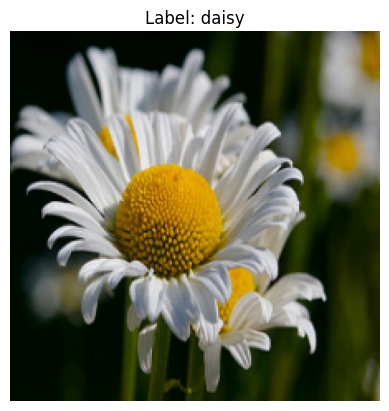

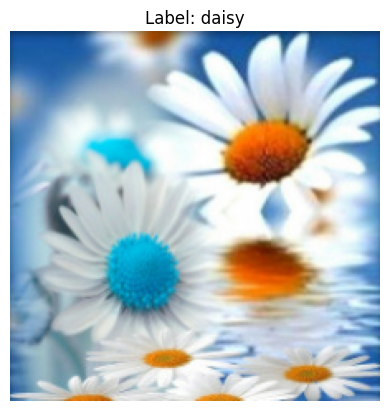

In [6]:
import matplotlib.pyplot as plt

for image_batch, label_batch in train_dataset.take(2):
    # Take the first image from the batch
    first_image = image_batch[0]
    first_label = label_batch[0]

    # Convert tensor to numpy array
    plt.imshow(first_image.numpy())
    plt.title(f"Label: {CLASS_NAMES[first_label]}")
    plt.axis('off')
    plt.show()

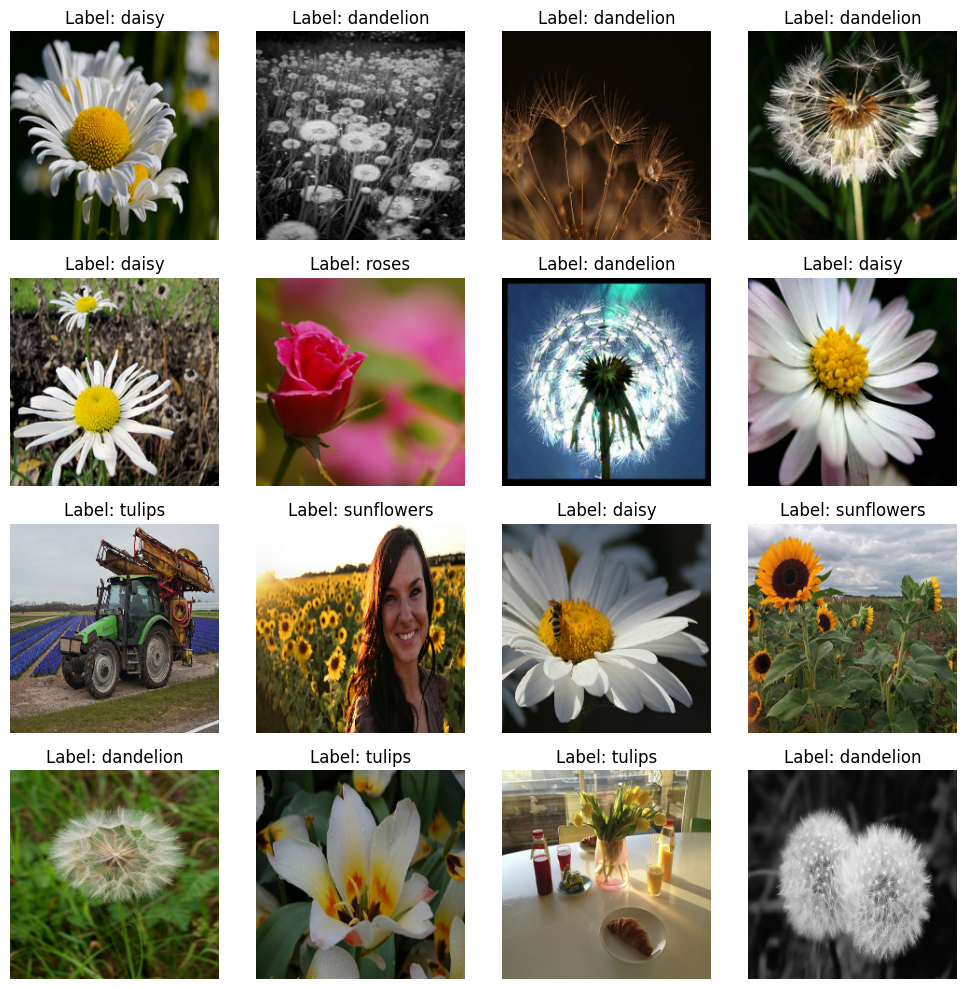

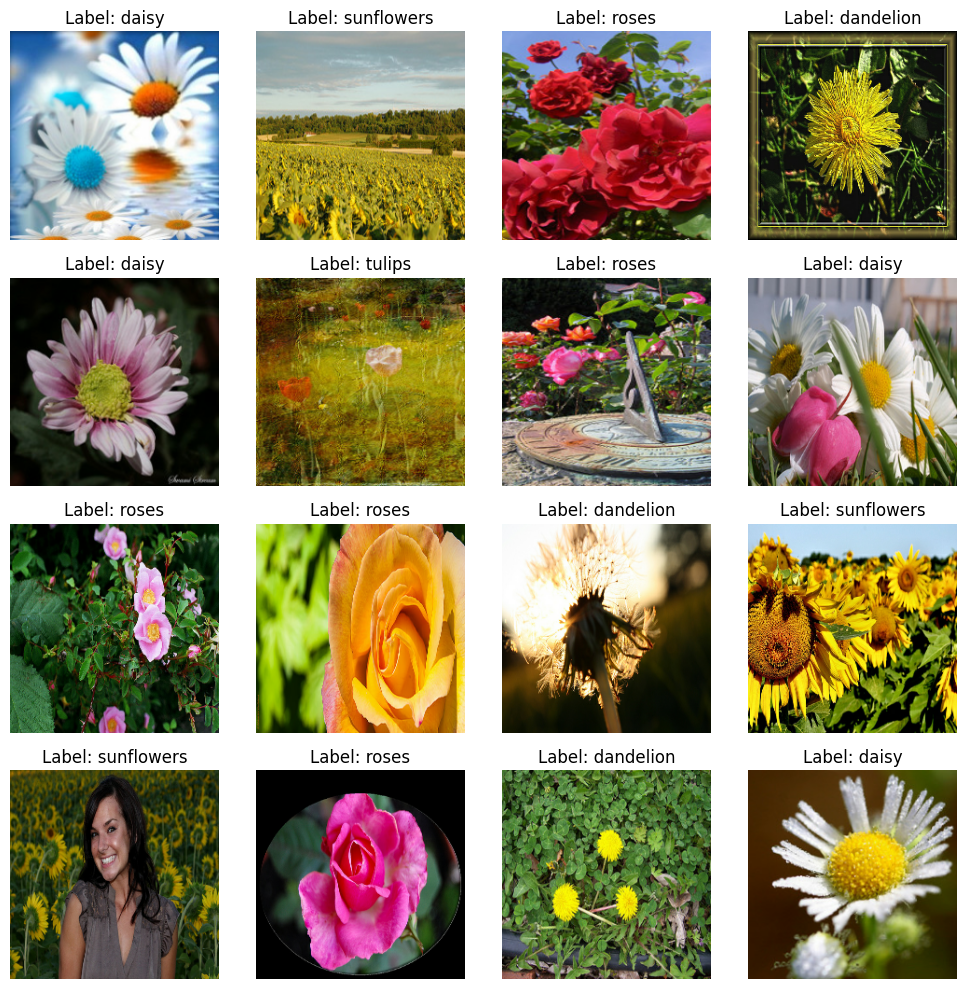

In [7]:
import matplotlib.pyplot as plt

# Take one batch from the dataset
for image_batch, label_batch in train_dataset.take(2):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # Create a 4x4 grid

    for i in range(16):  # Loop over the first 16 images
        ax = axes[i // 4, i % 4]  # Determine grid position
        ax.imshow(image_batch[i].numpy())  # Convert tensor to numpy array
        ax.set_title(f"Label: {CLASS_NAMES[label_batch[i]]}")
        ax.axis("off")  # Hide axes

    plt.tight_layout()
    plt.show()

In [13]:
from tensorflow import keras

model  = keras.Sequential([
    keras.layers.Flatten(input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(len(CLASS_NAMES), activation ="softmax")
])
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    # optimizer = "adam",
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
from IPython.core import history
EPOCHS = 5
history  = model.fit(
    train_dataset,
    validation_data  = eval_dataset,
    epochs = EPOCHS

)

Epoch 1/5
    207/Unknown 199s 954ms/step - accuracy: 0.2891 - loss: 25.9253

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


207/207 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.2893 - loss: 25.8655 - val_accuracy: 0.3622 - val_loss: 6.9465
Epoch 2/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 191s 730ms/step - accuracy: 0.4035 - loss: 5.6001 - val_accuracy: 0.3784 - val_loss: 4.5984
Epoch 3/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 112s 540ms/step - accuracy: 0.4175 - loss: 2.5063 - val_accuracy: 0.3216 - val_loss: 1.4958
Epoch 4/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 96s 465ms/step - accuracy: 0.3002 - loss: 1.5411 - val_accuracy: 0.2541 - val_loss: 1.5919
Epoch 5/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 89s 427ms/step - accuracy: 0.2804 - loss: 1.5695 - val_accuracy: 0.2324 - val_loss: 1.5906


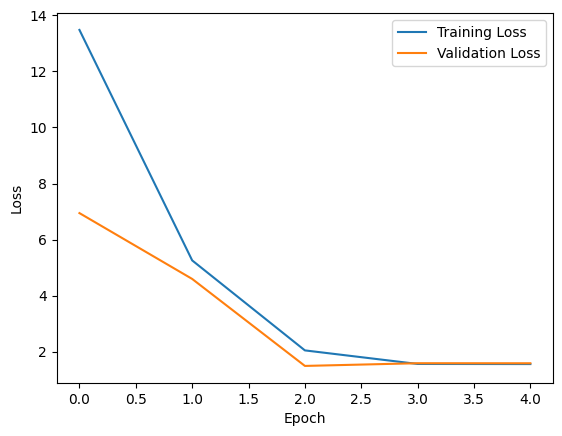

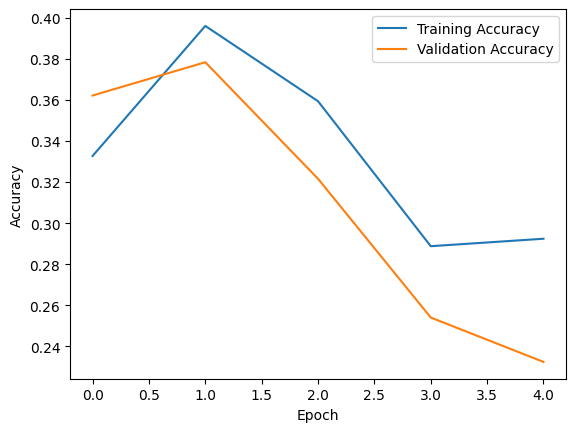

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [25]:
# Define datasets
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
  )

eval_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)

In [26]:
from tensorflow import keras
IMG_HEIGHT=64
IMG_WIDTH = 64
IMG_CHANNELS =3
model  = keras.Sequential([
    keras.layers.Flatten(input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(len(CLASS_NAMES), activation ="softmax")
])
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    # optimizer = "adam",
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [27]:
from IPython.core import history
EPOCHS = 5
history  = model.fit(
    train_dataset,
    validation_data  = eval_dataset,
    epochs = EPOCHS

)

Epoch 1/5
   3299/Unknown 88s 26ms/step - accuracy: 0.2489 - loss: 2.0116

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3300/3300 ━━━━━━━━━━━━━━━━━━━━ 97s 29ms/step - accuracy: 0.2489 - loss: 2.0114 - val_accuracy: 0.2514 - val_loss: 1.5933
Epoch 2/5
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 133s 27ms/step - accuracy: 0.2562 - loss: 1.5996 - val_accuracy: 0.2568 - val_loss: 1.5785
Epoch 3/5
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 86s 26ms/step - accuracy: 0.3020 - loss: 1.5526 - val_accuracy: 0.3243 - val_loss: 1.4998
Epoch 4/5
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 85s 26ms/step - accuracy: 0.3167 - loss: 1.4864 - val_accuracy: 0.3297 - val_loss: 1.4846
Epoch 5/5
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 88s 27ms/step - accuracy: 0.3226 - loss: 1.4613 - val_accuracy: 0.3270 - val_loss: 1.4870


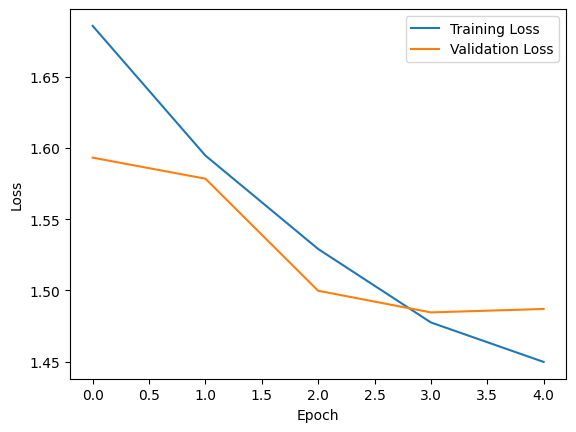

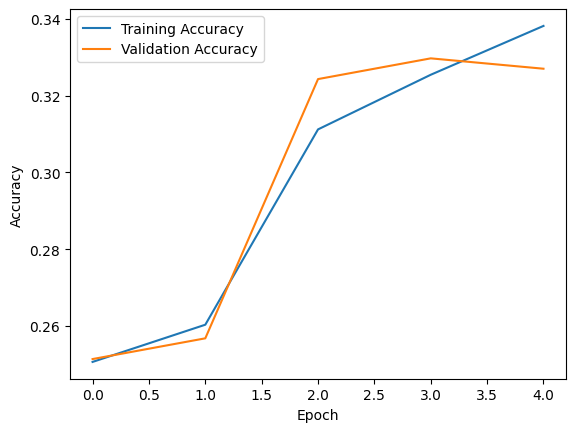

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [30]:
from tensorflow import keras

# Set IMG_HEIGHT, IMG_WIDTH, and IMG_CHANNELS before defining the datasets
IMG_HEIGHT=16
IMG_WIDTH = 16
IMG_CHANNELS =3

# Define datasets
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
  )

eval_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)


model  = keras.Sequential([
    keras.layers.Flatten(input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(len(CLASS_NAMES), activation ="softmax")
])
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    # optimizer = "adam",
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

from IPython.core import history
EPOCHS = 5
history  = model.fit(
    train_dataset,
    validation_data  = eval_dataset,
    epochs = EPOCHS

)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


     52/Unknown 70s 1s/step - accuracy: 0.3155 - loss: 1.5311

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.3165 - loss: 1.5296 - val_accuracy: 0.4135 - val_loss: 1.3339
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4723 - loss: 1.2645 - val_accuracy: 0.4595 - val_loss: 1.2584
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5051 - loss: 1.2054 - val_accuracy: 0.4730 - val_loss: 1.2252
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5322 - loss: 1.1671 - val_accuracy: 0.4838 - val_loss: 1.2056
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5424 - loss: 1.1349 - val_accuracy: 0.4622 - val_loss: 1.2043


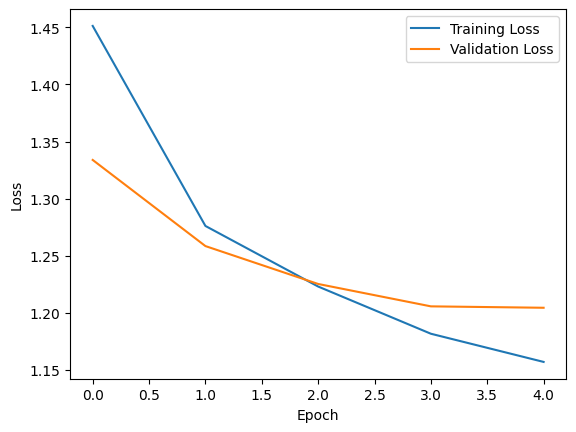

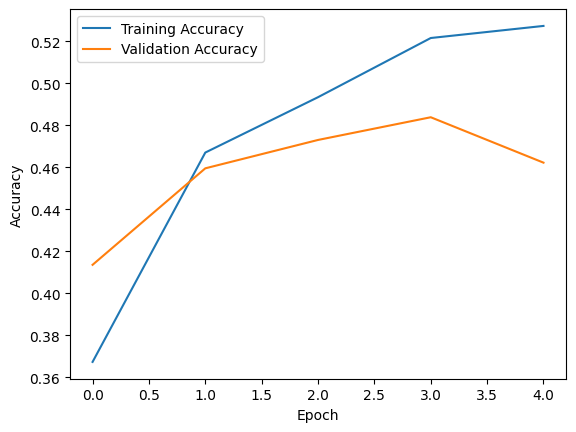

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [32]:
from tensorflow import keras

# Set IMG_HEIGHT, IMG_WIDTH, and IMG_CHANNELS before defining the datasets
IMG_HEIGHT=224
IMG_WIDTH = 224
IMG_CHANNELS =3

# Define datasets
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
  )

eval_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)


model  = keras.Sequential([
    keras.layers.Flatten(input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(len(CLASS_NAMES), activation ="softmax")
])
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    # optimizer = "adam",
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

from IPython.core import history
EPOCHS = 5
history  = model.fit(
    train_dataset,
    validation_data  = eval_dataset,
    epochs = EPOCHS

)

Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.2519 - loss: 41.5466 - val_accuracy: 0.4459 - val_loss: 4.7139
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.3942 - loss: 3.4281 - val_accuracy: 0.3973 - val_loss: 3.7555
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.3942 - loss: 3.2624 - val_accuracy: 0.3486 - val_loss: 2.3948
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.4956 - loss: 1.9572 - val_accuracy: 0.4216 - val_loss: 5.5229
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.4039 - loss: 4.2852 - val_accuracy: 0.4162 - val_loss: 2.8763


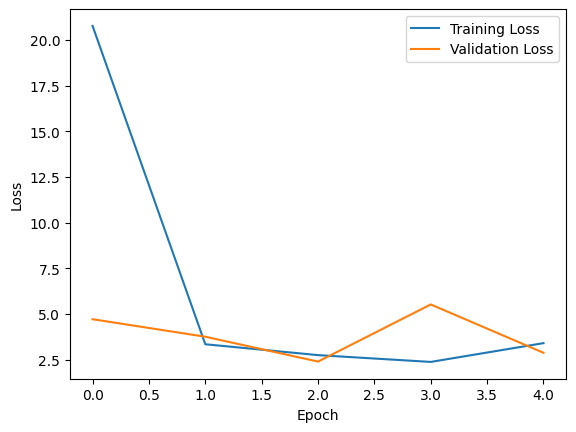

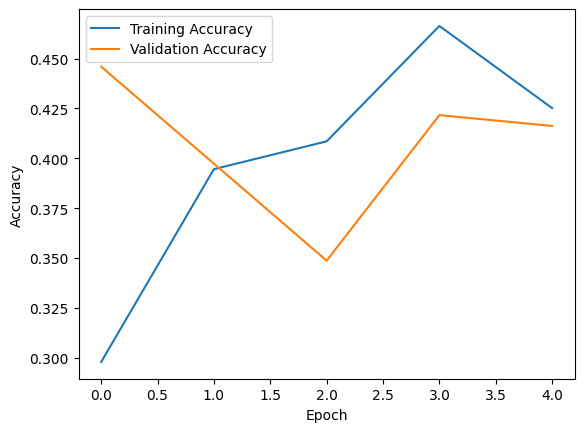

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [35]:
from tensorflow import keras

# Set IMG_HEIGHT, IMG_WIDTH, and IMG_CHANNELS before defining the datasets
IMG_HEIGHT=224
IMG_WIDTH = 224
IMG_CHANNELS =3

# Define datasets
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
  )

eval_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)


model  = keras.Sequential([
    keras.layers.Flatten(input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(len(CLASS_NAMES), activation ="softmax")
])
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    # optimizer = "adam",
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

from IPython.core import history
EPOCHS = 5
history  = model.fit(
    train_dataset,
    validation_data  = eval_dataset,
    epochs = EPOCHS

)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


     52/Unknown 85s 2s/step - accuracy: 0.2621 - loss: 22.4479

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.2627 - loss: 22.2740 - val_accuracy: 0.4135 - val_loss: 2.4386
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.3796 - loss: 2.9597 - val_accuracy: 0.3541 - val_loss: 3.8833
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.4023 - loss: 2.5846 - val_accuracy: 0.3919 - val_loss: 1.9987
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4704 - loss: 1.7044 - val_accuracy: 0.3946 - val_loss: 2.3790
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4859 - loss: 1.7797 - val_accuracy: 0.4703 - val_loss: 1.4054


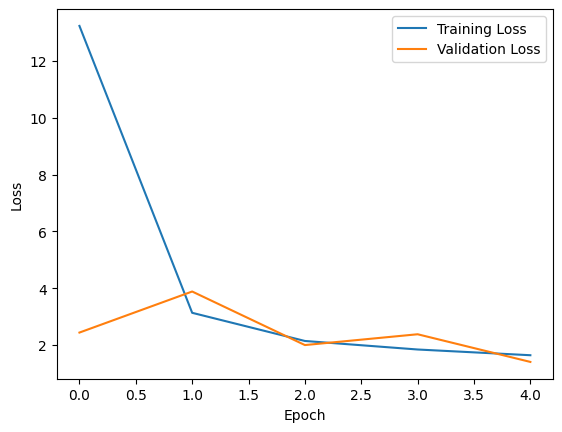

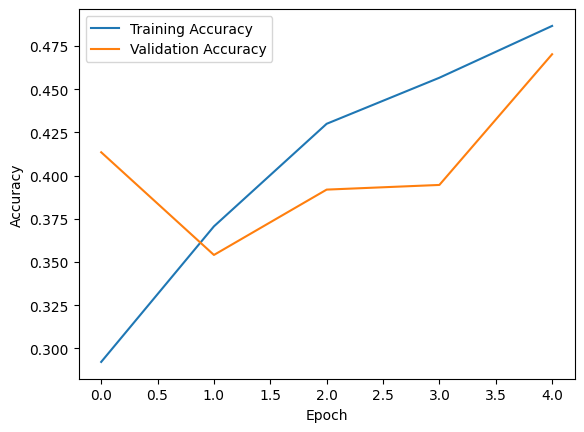

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [39]:
from tensorflow import keras

# Set IMG_HEIGHT, IMG_WIDTH, and IMG_CHANNELS before defining the datasets
IMG_HEIGHT=224
IMG_WIDTH = 224
IMG_CHANNELS =3

# Define datasets
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
  )

eval_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)


model  = keras.Sequential([
    keras.layers.Flatten(input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(len(CLASS_NAMES), activation ="softmax")
])
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    # optimizer = "adam",
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

from IPython.core import history
EPOCHS = 20
history  = model.fit(
    train_dataset,
    validation_data  = eval_dataset,
    epochs = EPOCHS

)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.2356 - loss: 17.9055 - val_accuracy: 0.2811 - val_loss: 6.4455
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.3530 - loss: 4.5222 - val_accuracy: 0.4270 - val_loss: 2.0152
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.4313 - loss: 1.9628 - val_accuracy: 0.4649 - val_loss: 1.4411
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.4511 - loss: 1.9815 - val_accuracy: 0.3811 - val_loss: 3.8659
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.4289 - loss: 2.4442 - val_accuracy: 0.4568 - val_loss: 1.5263
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5108 - loss: 1.2491 - val_accuracy: 0.4784 - val_loss: 1.4096
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5822 - loss: 1.0629 - val_accuracy: 0.4730 - val_loss: 1.4300
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5882 - loss: 1.0560 - val_accuracy: 0.4757 - val_los

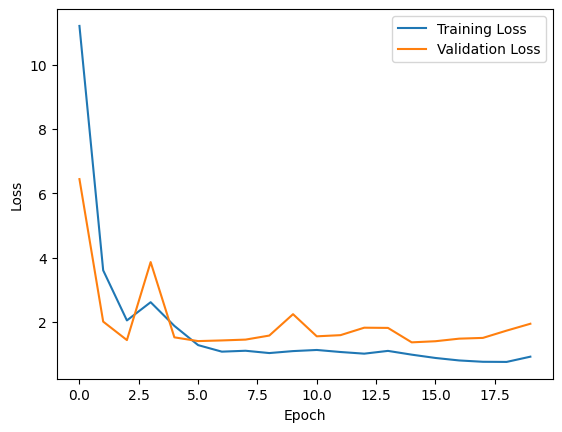

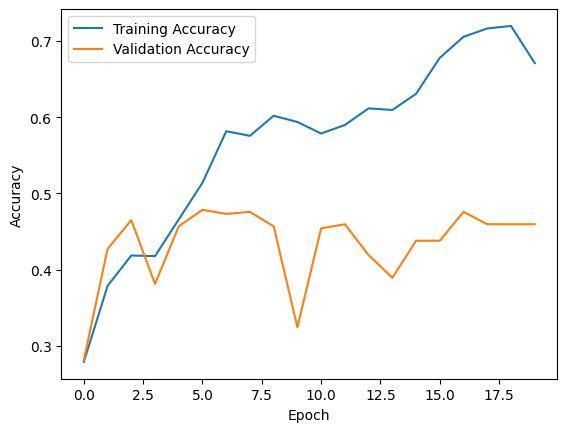

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Take exactly one batch from the evaluation dataset
for images, labels in eval_dataset.take(1):
    # Get model predictions for this batch
    batch_predictions = model.predict(images)
    predicted_indices = np.argmax(batch_predictions, axis=1)

    # Number of images in this batch
    num_images = images.shape[0]

    # Configure how many images to display per row
    num_cols = 4
    num_rows = math.ceil(num_images / num_cols)

    # Create a figure with a suitable size
    plt.figure(figsize=(12, 3 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        # Display the image
        plt.imshow(images[i].numpy())
        plt.axis('off')

        # Get predicted and actual class names
        pred_class = CLASS_NAMES[predicted_indices[i]]
        actual_class = CLASS_NAMES[labels[i].numpy()]

        # Show both predicted and actual labels as title
        plt.title(f"Pred: {pred_class}\nActual: {actual_class}", fontsize=10)

    # Adjust spacing to avoid overlapping titles, etc.
    plt.tight_layout()
    plt.show()